# Analysis across 50 world cities

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import planarity
import warnings
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from planar_analysis import *
from scipy import stats
from shapely import wkt
ox.config(use_cache=True, log_console=True)

In [2]:
df = pd.read_csv('data/results.csv', encoding='utf-8').drop('Unnamed: 0', axis=1)
df['geometry'] = df['geometry'].map(lambda x: wkt.loads(x))
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.crs = {'init': 'epsg:4326'}

In [3]:
gdf.head()

,city,count_cleaned_intersections,count_nonplanar_intersections,count_planar_intersections,country,distance,edge_length_ratio,geometry,is_planar,mean_edge_length,mean_planar_segment_length,network_type,nodes,overcount_nonplanar_cleaned,overcount_planar_cleaned,overcount_planar_nonplanar,phi,runtime
0,Buenos Aires,215,226,226,Argentina,805,1.000,POINT (-58.375547 -34.608657),True,108.662,108.662,drive,270,1.051,1.051,1.000,1.000,15.65
1,Buenos Aires,299,596,638,Argentina,805,0.936,POINT (-58.375547 -34.608657),False,56.903,53.272,walk,802,1.993,2.134,1.070,0.934,77.75
2,Sydney,148,174,239,Australia,805,0.734,POINT (151.208977 -33.863616),False,153.329,112.538,drive,220,1.176,1.615,1.374,0.728,12.08
3,Sydney,493,806,894,Australia,805,0.884,POINT (151.208977 -33.863616),False,53.840,47.587,walk,1026,1.635,1.813,1.109,0.902,121.21
4,Sao Paulo,285,327,425,Brazil,805,0.770,POINT (-46.6336 -23.549155),False,113.115,87.139,drive,412,1.147,1.491,1.300,0.769,27.87


In [4]:
# highest phi values
gdf[['city', 'phi']].sort_values(by='phi').head(10)

,city,phi
54,Moscow,0.540
84,Los Angeles,0.583
82,Dallas,0.584
86,Miami,0.641
15,Shanghai,0.660
70,Dubai,0.679
14,Shanghai,0.682
76,Atlanta,0.720
80,Cincinnati,0.722
2,Sydney,0.728


## map the results

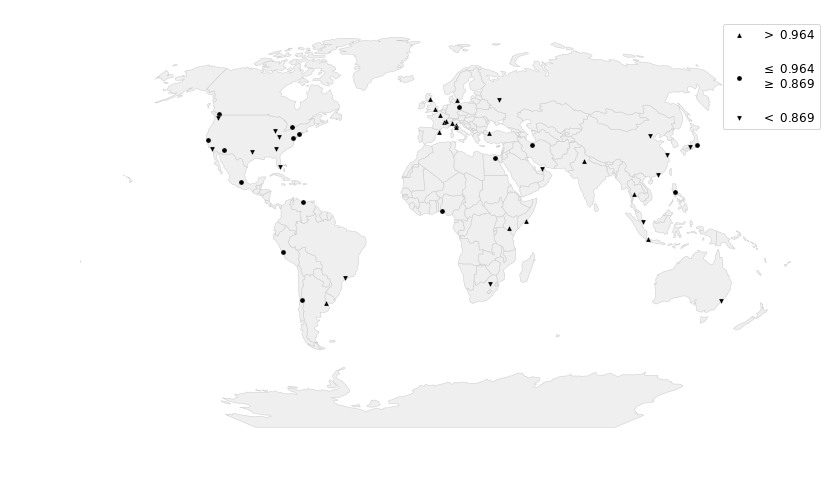

In [5]:
def get_marker(value, breaks):
    
    if value <= breaks[0]:
        return 1
    elif value <= breaks[1]:
        return 2
    else:
        return 3
    
drive = gdf[gdf['network_type']=='drive'].copy()
breaks = [drive['phi'].quantile(q=x) for x in (0.33, 0.67)]
drive['group'] = drive['phi'].apply(get_marker, breaks=breaks)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
crs_proj = '+proj=kav7'
world_proj = world.to_crs(crs_proj)
xmin, ymin, xmax, ymax = world_proj.unary_union.bounds
aspect_ratio = (xmax - xmin) / (ymax - ymin)
points_proj = drive.to_crs(crs_proj)

width = 14
fig, ax = plt.subplots(figsize=(width, width/aspect_ratio), facecolor='w')
ax = world_proj.plot(ax=ax, facecolor='#efefef', edgecolor='#cccccc', linewidth=0.5)

groups = []
points_proj[points_proj['group']==3].plot(ax=ax, marker='^', markersize=25, c='k', edgecolor='#cccccc', linewidth=0.3,
                                          label='$>$ {:.3f}'.format(breaks[1]))
points_proj[points_proj['group']==2].plot(ax=ax, marker='o', markersize=25, c='k', edgecolor='#cccccc', linewidth=0.3, 
                                          label='\n$\leq$ {:.3f}\n$\geq$ {:.3f}\n'.format(breaks[1], breaks[0]))
points_proj[points_proj['group']==1].plot(ax=ax, marker='v', markersize=25, c='k', edgecolor='#cccccc', linewidth=0.3, 
                                          label='$<$ {:.3f}'.format(breaks[0]))
    
plt.legend(prop={'size':12})

ax.axis('off')
fig.savefig('images/world_map_bw.svg', dpi=600)
plt.show()

## regression analysis

### first, untransformed linear model:

drive r^2=0.990, slope=0.906, intercept=0.093
walk r^2=0.994, slope=1.058, intercept=-0.061


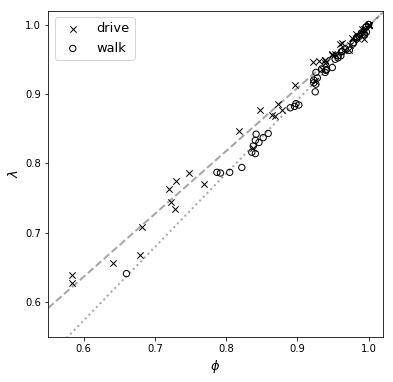

In [6]:
walk = gdf[gdf['network_type']=='walk']
drive = gdf[gdf['network_type']=='drive']
x = gdf['phi'].copy()
y = gdf['edge_length_ratio'].copy()
drive_x = drive['phi'].copy()
drive_y = drive['edge_length_ratio'].copy()
walk_x = walk['phi'].copy()
walk_y = walk['edge_length_ratio'].copy()

drive_slope, drive_intercept, drive_r_value, drive_p_value, drive_std_err = stats.linregress(drive_x, drive_y)
print('drive r^2={:.3f}, slope={:.3f}, intercept={:.3f}'.format(drive_r_value ** 2, drive_slope, drive_intercept))

walk_slope, walk_intercept, walk_r_value, walk_p_value, walk_std_err = stats.linregress(walk_x, walk_y)
print('walk r^2={:.3f}, slope={:.3f}, intercept={:.3f}'.format(walk_r_value ** 2, walk_slope, walk_intercept))

fig, ax = plt.subplots(figsize=(6,6))
drive_scatter = ax.scatter(x=drive_x, y=drive_y, c='k', edgecolor='none', s=40, linewidth=1, marker='x')
walk_scatter = ax.scatter(x=walk_x, y=walk_y, c='none', edgecolor='k', s=40, linewidth=1, marker='o')

# set x and y limits
x_min = 0.55
x_max = 1.02
y_min = 0.55
y_max = 1.02
ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

# create a line of best fit
x_line = np.array([x_min, x_max])

drive_Y_est = x_line * drive_slope + drive_intercept
drive_line = ax.plot(x_line, drive_Y_est, c='k', alpha=0.35, linestyle='--', linewidth=2, zorder=-1)

walk_Y_est = x_line * walk_slope + walk_intercept
walk_line = ax.plot(x_line, walk_Y_est, c='k', alpha=0.35, linestyle=':', linewidth=2, zorder=-1)

fontsize = 13
fontname = 'DejaVu Sans'
ax.set_xlabel(r'$\phi$', fontsize=fontsize, fontname=fontname)
ax.set_ylabel(r'$\lambda$', fontsize=fontsize, fontname=fontname)
plt.legend([drive_scatter, walk_scatter], ['drive', 'walk'], prop={'size':fontsize, 'family':fontname})

fig.savefig('images/regression_lambda_phi_linear.svg', dpi=600)
plt.show()

### or transform it to a log-log plot:

drive r^2=0.988, slope=0.879, intercept=-0.003
walk r^2=0.994, slope=1.069, intercept=-0.003


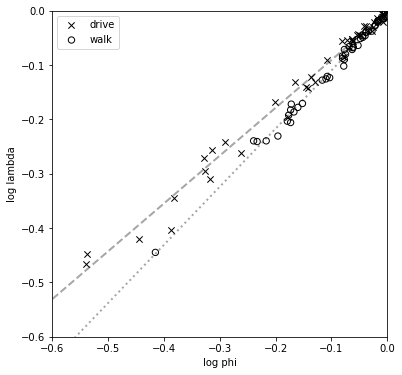

In [7]:
walk = gdf[gdf['network_type']=='walk']
drive = gdf[gdf['network_type']=='drive']

def transform(data):
    return np.log(data)

x = transform(gdf['phi'].copy())
y = transform(gdf['edge_length_ratio'].copy())
drive_x = transform(drive['phi'].copy())
drive_y = transform(drive['edge_length_ratio'].copy())
walk_x = transform(walk['phi'].copy())
walk_y = transform(walk['edge_length_ratio'].copy())

drive_slope, drive_intercept, drive_r_value, drive_p_value, drive_std_err = stats.linregress(drive_x, drive_y)
print('drive r^2={:.3f}, slope={:.3f}, intercept={:.3f}'.format(drive_r_value ** 2, drive_slope, drive_intercept))

walk_slope, walk_intercept, walk_r_value, walk_p_value, walk_std_err = stats.linregress(walk_x, walk_y)
print('walk r^2={:.3f}, slope={:.3f}, intercept={:.3f}'.format(walk_r_value ** 2, walk_slope, walk_intercept))

fig, ax = plt.subplots(figsize=(6,6))
drive_scatter = ax.scatter(x=drive_x, y=drive_y, c='k', edgecolor='none', s=40, linewidth=1, marker='x')
walk_scatter = ax.scatter(x=walk_x, y=walk_y, c='none', edgecolor='k', s=40, linewidth=1, marker='o')

# set x and y limits
x_min = -0.6
x_max = 0
y_min = -0.6
y_max = 0
ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

# create a line of best fit
x_line = np.array([x_min, x_max])

drive_Y_est = x_line * drive_slope + drive_intercept
drive_line = ax.plot(x_line, drive_Y_est, c='k', alpha=0.35, linestyle='--', linewidth=2, zorder=-1)

walk_Y_est = x_line * walk_slope + walk_intercept
walk_line = ax.plot(x_line, walk_Y_est, c='k', alpha=0.35, linestyle=':', linewidth=2, zorder=-1)

ax.set_xlabel('log phi')
ax.set_ylabel('log lambda')
plt.legend([drive_scatter, walk_scatter], ['drive', 'walk'])

#fig.savefig('data/regression_lambda_phi_loglog.png', dpi=300)
plt.show()

## make latex table

In [8]:
cols = ['country', 'city', 'network_type', 'is_planar', 'phi', 'edge_length_ratio']
table = gdf[cols].reindex(cols, axis=1).set_index(['country', 'city', 'network_type']).unstack(level=2)
table = table.swaplevel(i=0, j=1, axis=1)
table.columns = ['_'.join(col).strip() for col in table.columns]
table = table.rename(columns={'drive_edge_length_ratio' : 'd_ELR', 'drive_is_planar' : 'd_planar',
                      'drive_phi' : 'd_phi',
                      'walk_edge_length_ratio' : 'w_ELR', 'walk_is_planar' : 'w_planar',
                      'walk_phi' : 'w_phi'})
table = table.reindex(['d_planar', 'd_phi', 'd_ELR', 'w_planar', 'w_phi', 'w_ELR'], axis=1)
table['d_planar'] = table['d_planar'].map(lambda x: 'Yes' if x else 'No')
table['w_planar'] = table['w_planar'].map(lambda x: 'Yes' if x else 'No')
table

d_planar  d_phi  d_ELR w_planar  w_phi  w_ELR
country      city                                                       
Argentina    Buenos Aires       Yes  1.000  1.000       No  0.934  0.936
Australia    Sydney              No  0.728  0.734       No  0.902  0.884
Brazil       Sao Paulo           No  0.769  0.770       No  0.836  0.816
Canada       Toronto            Yes  0.922  0.946       No  0.838  0.825
             Vancouver           No  0.930  0.948       No  0.923  0.920
Chile        Santiago            No  0.873  0.885       No  0.967  0.965
China        Beijing             No  0.818  0.846       No  0.842  0.842
             Hong Kong           No  0.837  0.822       No  0.822  0.794
             Shanghai            No  0.682  0.708       No  0.660  0.641
Denmark      Copenhagen         Yes  0.992  0.988       No  0.994  0.985
Egypt        Cairo               No  0.897  0.913       No  0.898  0.886
France       Lyon                No  0.995  0.991       No  0.957  0.952
             Paris               No  0.982  0.987       No  0.925  0.903
Germany      Berlin              No  0.939  0.945       No  0.939  0.931
India        Delhi              Yes  1.000  1.000      Yes  0.997  0.989
Indonesia    Jakarta            Yes  0.990  0.994       No  0.983  0.981
Iran         Tehran              No  0.962  0.973       No  0.957  0.955
Italy        Bologna            Yes  1.000  1.000      Yes  0.996  0.996
             Florence           Yes  0.993  0.994       No  0.979  0.974
             Milan              Yes  1.000  1.000       No  0.846  0.830
Japan        Osaka               No  0.868  0.868       No  0.953  0.950
             Tokyo               No  0.925  0.919       No  0.926  0.914
Kenya        Nairobi             No  0.974  0.970       No  0.949  0.938
Mexico       Mexico City         No  0.939  0.949       No  0.926  0.931
Nigeria      Lagos               No  0.960  0.972       No  0.990  0.988
Peru         Lima                No  0.939  0.949       No  0.984  0.982
Philippines  Manila              No  0.940  0.946       No  0.896  0.882
Russia       Moscow              No  0.540  0.596       No  0.841  0.833
Singapore    Singapore           No  0.864  0.869       No  0.890  0.880
Somalia      Mogadishu          Yes  1.000  1.000      Yes  1.000  1.000
South Africa Johannesburg        No  0.847  0.877       No  0.997  0.997
Spain        Barcelona          Yes  1.000  1.000       No  0.923  0.916
Switzerland  Geneva              No  0.984  0.981       No  0.841  0.814
Thailand     Bangkok             No  0.993  0.979       No  0.992  0.986
Turkey       Istanbul            No  0.965  0.964       No  0.973  0.963
UAE          Dubai               No  0.679  0.668       No  0.852  0.837
UK           Edinburgh           No  0.973  0.964       No  0.987  0.983
             London              No  0.976  0.980       No  0.859  0.843
USA          Atlanta             No  0.720  0.763       No  0.805  0.787
             Chicago             No  0.748  0.786       No  0.792  0.786
             Cincinnati          No  0.722  0.744       No  0.940  0.934
             Dallas              No  0.584  0.639      Yes  0.961  0.955
             Los Angeles         No  0.583  0.628       No  0.787  0.787
             Miami               No  0.641  0.657       No  0.962  0.961
             New York            No  0.878  0.877       No  0.928  0.923
             Phoenix             No  0.949  0.958       No  0.978  0.972
             San Francisco       No  0.934  0.936       No  0.941  0.935
             Seattle             No  0.730  0.774       No  0.983  0.979
             Washington DC       No  0.948  0.956       No  0.963  0.961
Venezuela    Caracas             No  0.953  0.957      Yes  1.000  1.000

In [9]:
print(table.to_latex())

\begin{tabular}{lllrrlrr}
\toprule
          &         & d\_planar &  d\_phi &  d\_ELR & w\_planar &  w\_phi &  w\_ELR \\
country & city &          &        &        &          &        &        \\
\midrule
Argentina & Buenos Aires &      Yes &  1.000 &  1.000 &       No &  0.934 &  0.936 \\
Australia & Sydney &       No &  0.728 &  0.734 &       No &  0.902 &  0.884 \\
Brazil & Sao Paulo &       No &  0.769 &  0.770 &       No &  0.836 &  0.816 \\
Canada & Toronto &      Yes &  0.922 &  0.946 &       No &  0.838 &  0.825 \\
          & Vancouver &       No &  0.930 &  0.948 &       No &  0.923 &  0.920 \\
Chile & Santiago &       No &  0.873 &  0.885 &       No &  0.967 &  0.965 \\
China & Beijing &       No &  0.818 &  0.846 &       No &  0.842 &  0.842 \\
          & Hong Kong &       No &  0.837 &  0.822 &       No &  0.822 &  0.794 \\
          & Shanghai &       No &  0.682 &  0.708 &       No &  0.660 &  0.641 \\
Denmark & Copenhagen &      Yes &  0.992 &  0.988 &       No &  0.

# More detailed summary statistics

In [10]:
walk = pd.read_csv('data/results_walk.csv')
drive = pd.read_csv('data/results_drive.csv')

In [11]:
walk.columns

Index(['country', 'city', 'distance', 'network_type',
       'count_cleaned_intersections', 'count_nonplanar_intersections',
       'count_planar_intersections', 'edge_length_ratio', 'geometry',
       'is_planar', 'mean_edge_length', 'mean_planar_segment_length', 'nodes',
       'overcount_nonplanar_cleaned', 'overcount_planar_cleaned',
       'overcount_planar_nonplanar', 'phi', 'runtime'],
      dtype='object')

In [12]:
print(drive['is_planar'].sum() / len(walk))
print(drive['phi'].mean())
print(drive['phi'].min())
print(drive['phi'].max())
print(drive['edge_length_ratio'].mean())
print(drive['edge_length_ratio'].min())
print(drive['edge_length_ratio'].max())
print((drive['phi']==1).sum())
print((drive['edge_length_ratio']==1).sum())

0.2
0.8813000000000001
0.54
1.0
0.8914
0.596
1.0
6
6


In [13]:
print(walk['is_planar'].sum() / len(walk))
print(walk['phi'].mean())
print(walk['phi'].min())
print(walk['phi'].max())
print(walk['edge_length_ratio'].mean())
print(walk['edge_length_ratio'].min())
print(walk['edge_length_ratio'].max())
print((walk['phi']==1).sum())
print((walk['edge_length_ratio']==1).sum())

0.1
0.9202800000000001
0.66
1.0
0.91244
0.6409999999999999
1.0
2
2


In [14]:
drive.sort_values('phi', ascending=True)

,country,city,distance,network_type,count_cleaned_intersections,count_nonplanar_intersections,count_planar_intersections,edge_length_ratio,geometry,is_planar,mean_edge_length,mean_planar_segment_length,nodes,overcount_nonplanar_cleaned,overcount_planar_cleaned,overcount_planar_nonplanar,phi,runtime
27,Russia,Moscow,805,drive,58,68,126,0.596,POINT (37.537873 55.749165),False,246.170,146.740,110,1.172,2.172,1.853,0.540,4.50
42,USA,Los Angeles,805,drive,164,183,314,0.628,POINT (-118.249837 34.056394),False,160.918,101.075,251,1.116,1.915,1.716,0.583,14.90
41,USA,Dallas,805,drive,228,300,514,0.639,POINT (-96.805628 32.777714),False,135.856,86.790,380,1.316,2.254,1.713,0.584,25.52
43,USA,Miami,805,drive,185,220,343,0.657,POINT (-80.19443199999999 25.7725),False,124.681,81.945,283,1.189,1.854,1.559,0.641,15.29
35,UAE,Dubai,805,drive,152,197,290,0.668,POINT (55.274985 25.202671),False,169.929,113.486,243,1.296,1.908,1.472,0.679,11.78
7,China,Shanghai,805,drive,109,176,258,0.708,POINT (121.503787 31.236286),False,161.555,114.459,215,1.615,2.367,1.466,0.682,10.97
38,USA,Atlanta,805,drive,190,198,275,0.763,POINT (-84.386107 33.756297),False,132.039,100.799,253,1.042,1.447,1.389,0.720,15.23
40,USA,Cincinnati,805,drive,207,236,327,0.744,POINT (-84.514753 39.101593),False,135.026,100.511,308,1.140,1.580,1.386,0.722,19.64
1,Australia,Sydney,805,drive,148,174,239,0.734,POINT (151.208977 -33.863616),False,153.329,112.538,220,1.176,1.615,1.374,0.728,12.08
47,USA,Seattle,805,drive,257,268,367,0.774,POINT (-122.33445 47.61117),False,114.769,88.879,349,1.043,1.428,1.369,0.730,26.84


In [15]:
drive[drive['is_planar'] == True].sort_values('phi')[['city', 'phi', 'edge_length_ratio']]

,city,phi,edge_length_ratio
3,Toronto,0.922,0.946
15,Jakarta,0.990,0.994
9,Copenhagen,0.992,0.988
18,Florence,0.993,0.994
0,Buenos Aires,1.000,1.000
14,Delhi,1.000,1.000
17,Bologna,1.000,1.000
19,Milan,1.000,1.000
29,Mogadishu,1.000,1.000
31,Barcelona,1.000,1.000


In [16]:
walk[walk['is_planar'] == True].sort_values('phi')[['city', 'phi', 'edge_length_ratio']]

,city,phi,edge_length_ratio
41,Dallas,0.961,0.955
17,Bologna,0.996,0.996
14,Delhi,0.997,0.989
29,Mogadishu,1.000,1.000
49,Caracas,1.000,1.000


In [17]:
drive['drive_walk_phi'] = (walk['phi'] / drive['phi'])
drive[['city', 'drive_walk_phi']].sort_values('drive_walk_phi')

,city,drive_walk_phi
19,Milan,0.846000
32,Geneva,0.854675
37,London,0.880123
3,Toronto,0.908894
31,Barcelona,0.923000
0,Buenos Aires,0.934000
12,Paris,0.941955
26,Manila,0.953191
11,Lyon,0.961809
7,Shanghai,0.967742


In [18]:
print(drive['overcount_planar_nonplanar'].mean())
print(1 - drive['edge_length_ratio'].mean())
print(walk['overcount_planar_nonplanar'].mean())
print(1 - walk['edge_length_ratio'].mean())

1.1647800000000001
0.10860000000000003
1.0941999999999998
0.08755999999999997


True


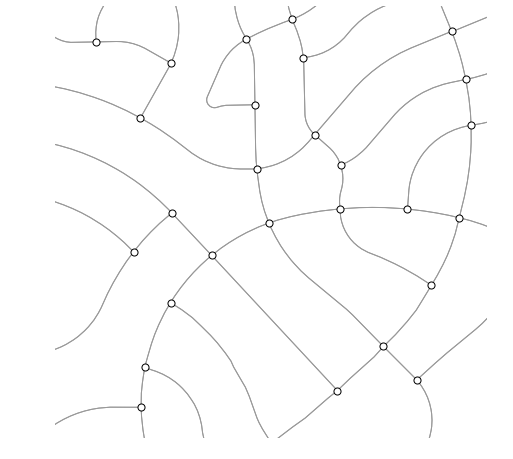

In [19]:
pt = (38.586683, -121.375365)
dist = 500

G = ox.graph_from_point(pt, network_type='drive', distance=dist*2, truncate_by_edge=True)
G = ox.project_graph(G)

warnings.filterwarnings(action='ignore')
print(planarity.is_planar(G))
warnings.filterwarnings(action='default')

bbox = ox.bbox_from_point(pt, dist, project_utm=True)
fig, ax = ox.plot_graph(G, bbox=bbox, fig_height=6, fig_width=6, 
                        node_size=50, node_zorder=2, node_color='w', node_edgecolor='k',
                        save=True, filename='planar', file_format='svg', dpi=600, margin=0)

#fig.savefig(fname='images/planar.png', dpi=600)

False


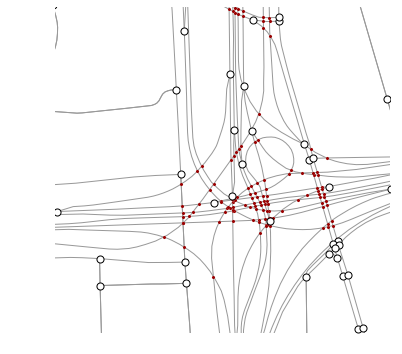

In [20]:
# define center point and bounding box
coords = (32.909035, -96.898432)
bbox = ox.bbox_from_point(coords, dist, project_utm=True)
north, south, east, west = bbox
poly = Polygon([(west, north), (west, south), (east, south), (east, north)])

# get a buffered graph
G = ox.graph_from_point(coords, network_type='drive', distance=dist*2, truncate_by_edge=True)
G = ox.project_graph(G)

# do planarity analysis so we can plot non-intersection line-crossings
planar_intersections = calculate_planar_intersections(G, poly)

# test formal planarity
warnings.filterwarnings(action='ignore')
print(planarity.is_planar(G))
warnings.filterwarnings(action='default')

# plot graph
fig, ax = ox.plot_graph(G, bbox=bbox, fig_height=6, fig_width=6, 
                        node_size=50, node_zorder=3, node_color='w', node_edgecolor='k',
                        save=False, show=False, close=False, margin=0)

# scatter plot line crossings
x = planar_intersections.map(lambda pt: pt.x)
y = planar_intersections.map(lambda pt: pt.y)
ax.scatter(x, y, s=10, c='#990000', edgecolors='w', linewidths=0.1, zorder=2)

fig.savefig(fname='images/nonplanar.svg', dpi=600)
#fig.savefig(fname='images/nonplanar.png', dpi=600)
plt.show()

# Single city analysis

In [21]:
df = pd.read_csv('data/city_samples.csv').drop('Unnamed: 0', axis=1)
df.head()

,coords,count_cleaned_intersections,count_nonplanar_intersections,count_planar_intersections,distance,edge_length_ratio,is_planar,mean_edge_length,mean_planar_segment_length,name,network_type,nodes,overcount_nonplanar_cleaned,overcount_planar_cleaned,overcount_planar_nonplanar,phi,runtime
0,"(37.81457038291894, -122.25529153926769)",205,251,291,805,0.883985,False,117.965467,104.279670,"00_Oakland, California, USA",drive,300,1.224390,1.419512,1.159363,0.862543,24.029637
1,"(37.80568383476944, -122.25476751037529)",170,201,205,805,0.981220,True,107.174370,105.161688,"01_Oakland, California, USA",drive,261,1.182353,1.205882,1.019900,0.980488,23.585007
2,"(37.807481931575765, -122.28028026741039)",231,290,366,805,0.831538,False,112.620406,93.648096,"02_Oakland, California, USA",drive,353,1.255411,1.584416,1.262069,0.792350,32.123001
3,"(37.80936423077242, -122.2137352007491)",141,157,157,805,1.000000,True,144.187262,144.187245,"04_Oakland, California, USA",drive,225,1.113475,1.113475,1.000000,1.000000,16.023003
4,"(37.737072168646584, -122.18838543235465)",139,159,177,805,0.922819,False,132.834136,122.581820,"05_Oakland, California, USA",drive,226,1.143885,1.273381,1.113208,0.898305,15.483002


In [22]:
df['overcount_planar_nonplanar'].mean()

1.0908427182636742

In [23]:
df['phi'] = 1 / df['overcount_planar_nonplanar']
cols = ['phi', 'edge_length_ratio']
df2 = df[cols].copy().head(100)
table = df2[cols].describe().round(3)
table = table.loc[['mean', 'std', 'min', 'max']]
table

,phi,edge_length_ratio
mean,0.929,0.939
std,0.103,0.089
min,0.569,0.567
max,1.000,1.000


In [24]:
print(table.to_latex())

\begin{tabular}{lrr}
\toprule
{} &    phi &  edge\_length\_ratio \\
\midrule
mean &  0.929 &              0.939 \\
std  &  0.103 &              0.089 \\
min  &  0.569 &              0.567 \\
max  &  1.000 &              1.000 \\
\bottomrule
\end{tabular}



In [25]:
df.head(100)['is_planar'].value_counts()

True     67
False    33
Name: is_planar, dtype: int64

In [26]:
len(df.head(100)[df.head(100)['overcount_planar_nonplanar'] > 1])

63